# Autoencoder For Realz

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/Users/erikallen/.virtualenvs/generative-models/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Load data from https://www.openml.org/d/554
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [3]:
X, Y = fetch_openml('mnist_784', version=1, return_X_y=True)
Y = np.array([int(o) for o in Y])
X /= 255.0
X = X.reshape(X.shape[0], 28, 28)
X = np.expand_dims(X, axis=-1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1/7, random_state=42)
print(X_train.shape, type(X_train))

(60000, 28, 28, 1) <class 'numpy.ndarray'>


In [5]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        # initialize the input shape to be "channels last" along with
        # the channels dimension itself
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # define the input to the encoder
        inputs = Input(shape=inputShape)
        x = inputs

        # loop over the number of filters
        for f in filters:
            # apply a CONV => RELU => BN operation
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        # flatten the network and then construct our latent vector
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)

        # build the encoder model
        encoder = Model(inputs, latent, name="encoder")

        # start building the decoder model which will accept the
        # output of the encoder as its inputs
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        # loop over our number of filters again, but this time in
        # reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (3, 3), strides=2,
                padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        # apply a single CONV_TRANSPOSE layer used to recover the
        # original depth of the image
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)

        # build the decoder model
        decoder = Model(latentInputs, outputs, name="decoder")

        # our autoencoder is the encoder + decoder
        autoencoder = Model(inputs, decoder(encoder(inputs)),
            name="autoencoder")

        # return a 3-tuple of the encoder, decoder, and autoencoder
        return (encoder, decoder, autoencoder)

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32

[INFO] building autoencoder...
Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.0185 - val_loss: 0.0108
Epoch 2/25
60000/60000 [==============================] - 67s 1ms/sample - loss: 0.0102 - val_loss: 0.0096
Epoch 3/25
60000/60000 [==============================] - 81s 1ms/sample - loss: 0.0092 - val_loss: 0.0090
Epoch 4/25
60000/60000 [==============================] - 79s 1ms/sample - loss: 0.0086 - val_loss: 0.0083
Epoch 5/25
60000/60000 [==============================] - 81s 1ms/sample - loss: 0.0083 - val_loss: 0.0080
Epoch 6/25
60000/60000 [==============================] - 81s 1ms/sample - loss: 0.0080 - val_loss: 0.0078
Epoch 7/25
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0077 - val_loss: 0.0079
Epoch 8/25
60000/60000 [==============================] - 82s 1ms/sample - loss: 0.0076 - val_loss: 0.0076
Epoch 9/25
60000/60000 [==============================] - 83s 1

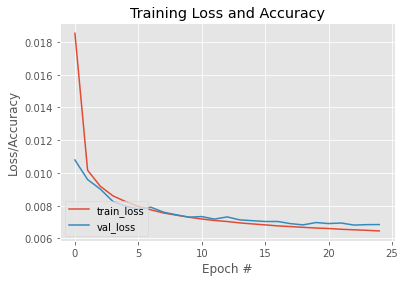

In [7]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=EPOCHS,
    batch_size=BS)

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [8]:
# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO] making predictions...")
Xp_test = autoencoder.predict(X_test)
Xp_train = autoencoder.predict(X_train)
outputs = None

[INFO] making predictions...


In [9]:
mse_train = (np.square(Xp_train - X_train)).mean(axis=None)
mse_test = (np.square(Xp_test - X_test)).mean(axis=None)
print(mse_train, mse_test)

0.006376434699754119 0.006847358749420064


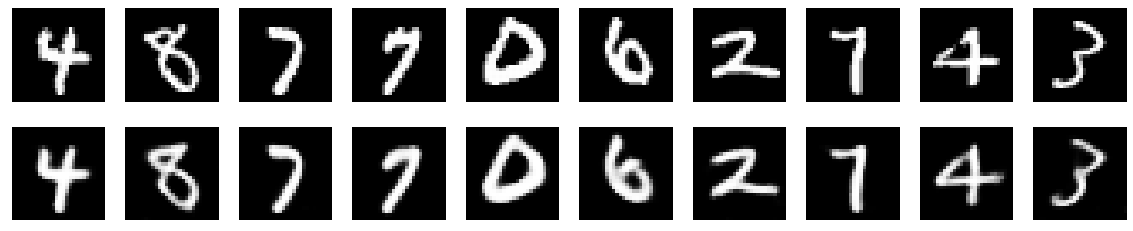

In [10]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(Xp_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising

In [11]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

[INFO] building autoencoder...
Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.0883 - val_loss: 0.0853
Epoch 2/25
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.0848 - val_loss: 0.0848
Epoch 3/25
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.0843 - val_loss: 0.0843
Epoch 4/25
60000/60000 [==============================] - 70s 1ms/sample - loss: 0.0840 - val_loss: 0.0841
Epoch 5/25
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.0838 - val_loss: 0.0839
Epoch 6/25
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.0837 - val_loss: 0.0838
Epoch 7/25
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.0836 - val_loss: 0.0837
Epoch 8/25
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.0835 - val_loss: 0.0836
Epoch 9/25
60000/60000 [==============================] - 72s 1

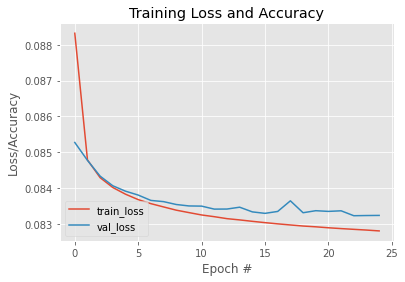

In [13]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
    X_train_noisy, X_train_noisy,
    validation_data=(X_test_noisy, X_test_noisy),
    epochs=EPOCHS,
    batch_size=BS)

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [14]:
# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO] making predictions...")
Xp_test_noisy = autoencoder.predict(X_test_noisy)
Xp_train_noisy = autoencoder.predict(X_train_noisy)
outputs = None

[INFO] making predictions...


In [15]:
mse_train = (np.square(Xp_train_noisy - X_train)).mean(axis=None)
mse_test = (np.square(Xp_test_noisy - X_test)).mean(axis=None)
print(mse_train, mse_test)

0.04436128713562186 0.04469700708001843


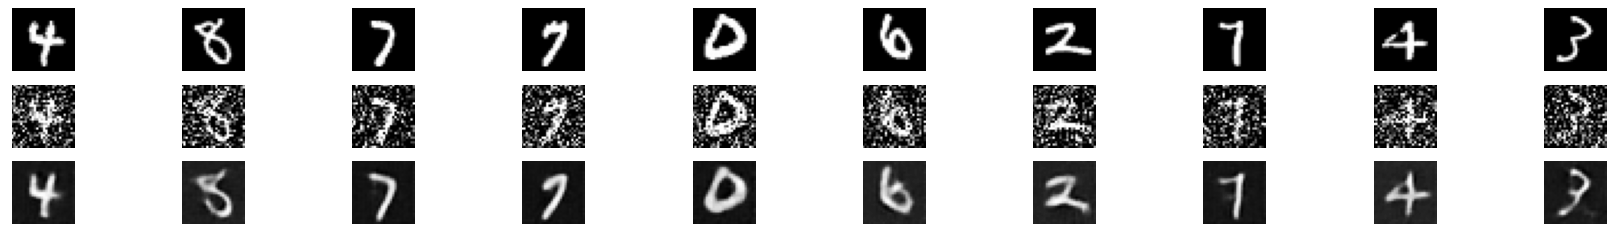

In [16]:
n = 10
plt.figure(figsize=(30, 4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display noisy
    ax = plt.subplot(3, n, i + n)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 2 * n)
    plt.imshow(Xp_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()